In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, betas_ns_ols
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from scipy.optimize import minimize
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
def missing_values_table(df):
    """
    Input: A data frame
    Ouput: Amount of missing values,
         Percentage of missing values in each feature
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [3]:
def plot_3d_nelson_siegel(data, maturity, start_date=2016, end_date=2019):
    
    x = np.array(np.linspace(start_date, end_date, len(data)))
    y = maturity
    x, y = np.meshgrid(x, y)
    z = data.values.T
    assert x.shape == y.shape, f'{x.shape} != {y.shape}'
    assert x.shape == z.shape, f'{x.shape} != {z.shape}'

    # Set up plot
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_zlabel('Rate', fontsize=10)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Maturity (Yearly)', fontsize=10)
    ax.set_title('Yield Surface of Historical data')
    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                           linewidth=0, antialiased=False, shade=False)
    plt.show()
    return None

# Formatting and Cleaning data

In [4]:
data = pd.read_csv('OIS-daily-data_2016-to-present.csv').dropna()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', drop=True, inplace=True)

# Select maturity and columns
month_maturity = np.arange(1,61)
column = month_maturity.astype(str)
year_maturity = month_maturity / 12
data = data / 100
print("Number of (row, column): ", data.shape)


Number of (row, column):  (991, 60)


# Demo a Yield Curve

NelsonSiegelCurve(beta0=0.0072071568366448464, beta1=-6.259165113896726e-06, beta2=-0.006544258815061797, tau=1.39407259)


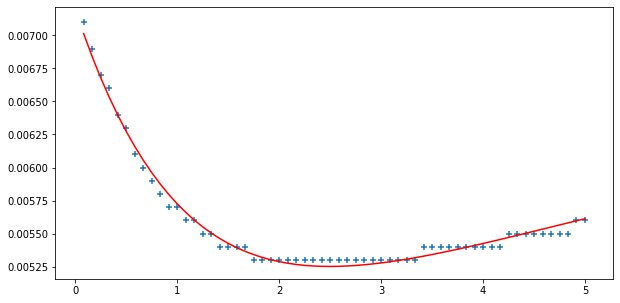

In [9]:
t = year_maturity
y = data.loc['2019-11-22'].values
tau = 1.39407259

curve, _ = betas_ns_ols(tau, t, y)
print(curve)
plt.figure(figsize=(10,5))
plt.plot(t, curve(t), c='red')
plt.scatter(t, y, marker='+')
plt.show()

# Find Tau

In [6]:
def neg_medium_term(tau):
    a = (30/12) / tau
    return -(((1 - np.exp(-a)) / a) - np.exp(-a))

In [7]:
minimize(neg_medium_term, x0=0.0609)

      fun: -0.29842560750304675
 hess_inv: array([[8.12776234]])
      jac: array([-2.3432076e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([1.39407259])

In [50]:
tau = 1.39407259

We choose $\tau = 1.39407259$ as the result the solver gave us which is a method in Diebold (2006).

# Find betas

In [10]:
def compute_nelson_param(df):
    y = df.values
    t = year_maturity
    while True:
        try: 
            curve, _ = betas_ns_ols(tau, t, y)
            return [curve.beta0, curve.beta1, curve.beta2]
        except:
            print(f"Error at {df.index}")
            return [np.nan]*3

In [11]:
data[['beta0', 'beta1', 'beta2']] = data.apply(lambda x: pd.Series(compute_nelson_param(x), index=['beta0', 'beta1', 'beta2']), axis=1)

In [12]:
data.to_csv('data_NS_params_tau_1.39407259.csv')
data.shape

(991, 63)

# Plot 3d Nelson Siegel

In [13]:
data = pd.read_csv('data_NS_params_tau_1.39407259.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.interpolate(inplace=True, )
data.shape

(991, 63)

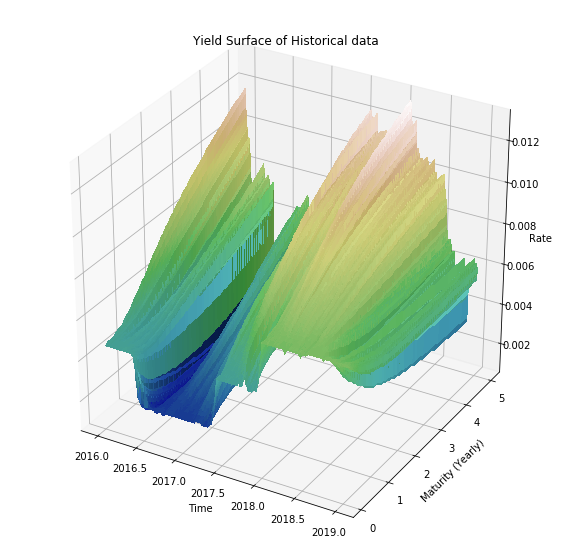

In [14]:
plot_3d_nelson_siegel(data[column], year_maturity)

# Simulate 2 years term structure

In [15]:
# Select data
beta0 = data.beta0.values
beta1 = data.beta1.values
beta2 = data.beta2.values

# Select model for each data
ar_beta0_ = AR(beta0).fit(maxlag=1)
ar_beta1_ = AR(beta1).fit(maxlag=1)
ar_beta2_ = AR(beta2).fit(maxlag=1)

# Estimated coefficient
print(ar_beta0_.params)
print(ar_beta1_.params)
print(ar_beta2_.params)

[1.52972209e-04 9.83976301e-01]
[-6.34755074e-05  9.85959994e-01]
[-1.08785354e-04  9.79502411e-01]


In [16]:
np.sqrt(np.var(ar_beta0_.resid))

0.000550186104153757

In [17]:
# Simulate beta0
beta0_simulate = {}
beta1_simulate = {}
beta2_simulate = {}
sd0 = np.sqrt(np.var(ar_beta0_.resid))
sd1 = np.sqrt(np.var(ar_beta1_.resid))
sd2 = np.sqrt(np.var(ar_beta2_.resid))

h = 1000
n = len(beta0)
# sd = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

# for _ in sd:
#     # Simulate beta0
#     beta0_simulate['beta0_' + str(_)] = ar_beta0_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

#     # Simulate beta1
#     beta1_simulate['beta1_' + str(_)] = ar_beta1_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

#     # Simulate beta2
#     beta2_simulate['beta2_' + str(_)] = ar_beta2_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

# Simulate beta0
beta0_simulate['beta0'] = ar_beta0_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd0, size=h)

# Simulate beta1
beta1_simulate['beta1'] = ar_beta1_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd1, size=h)

# Simulate beta2
beta2_simulate['beta2'] = ar_beta2_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd2, size=h)

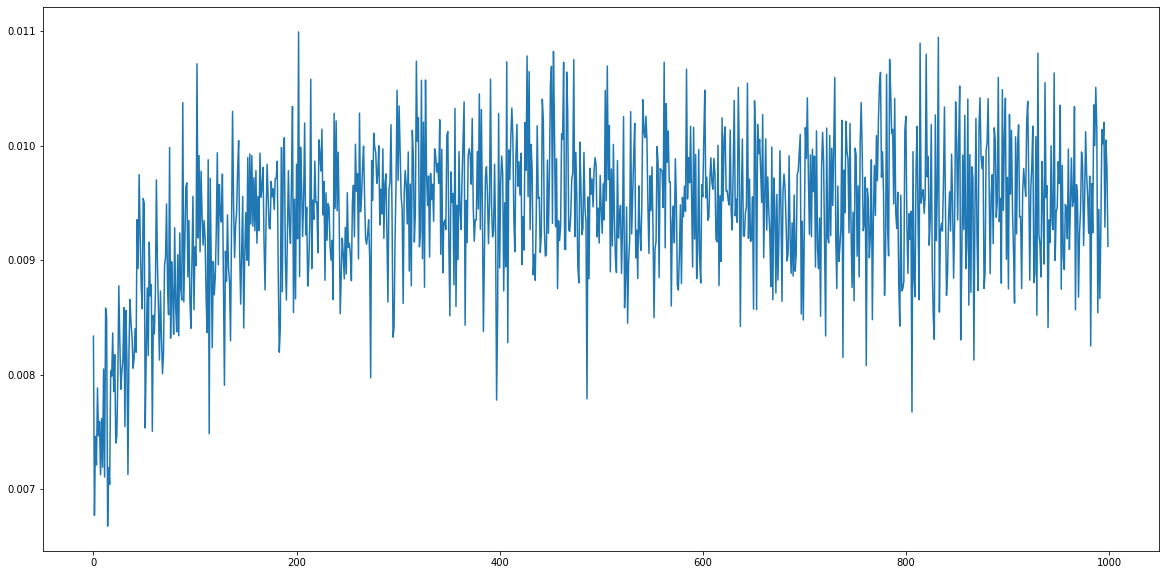

In [18]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta0_simulate:
    plt.plot( beta0_simulate[series])

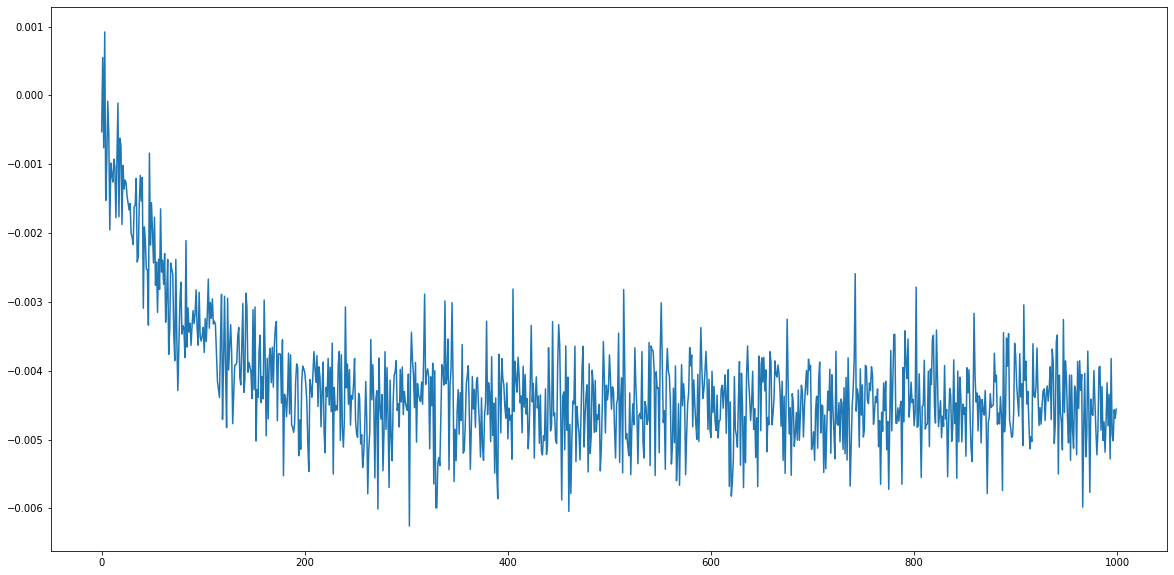

In [19]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta1_simulate:
    plt.plot( beta1_simulate[series])

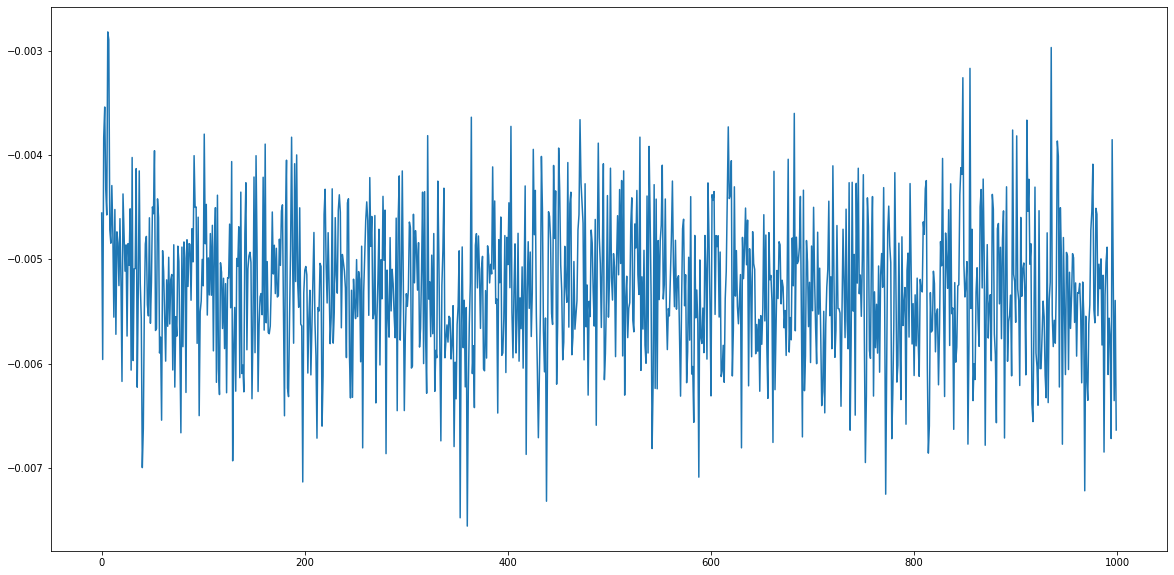

In [20]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta2_simulate:
    plt.plot( beta2_simulate[series])

In [21]:
df_beta0_simulate = pd.DataFrame(beta0_simulate)
df_beta1_simulate = pd.DataFrame(beta1_simulate)
df_beta2_simulate = pd.DataFrame(beta2_simulate)

In [22]:
df_param_simulate = pd.concat(
    [df_beta0_simulate, df_beta1_simulate, df_beta2_simulate], axis=1)
df_yield_simulate = pd.DataFrame()

# for m in year_maturity:
#     m = round(m,4)
#     for s in sd:
#         df_yield_simulate[str(m)+'_sd_'+str(s)] = NelsonSiegelCurve(df_param_simulate['beta0_'+str(s)],
#                                                df_param_simulate['beta1_'+str(s)],
#                                                df_param_simulate['beta2_'+str(s)], tau)(m)

for m in year_maturity:
    m = round(m,4)
    df_yield_simulate[str(m)] = NelsonSiegelCurve(df_param_simulate['beta0'],
                                           df_param_simulate['beta1'],
                                           df_param_simulate['beta2'], tau)(m)

In [25]:
df_yield_simulate.head()

,0.0833,0.1667,0.25,0.3333,0.4167,0.5,0.5833,0.6667,0.75,0.8333,...,4.25,4.3333,4.4167,4.5,4.5833,4.6667,4.75,4.8333,4.9167,5.0
0,0.007694,0.007588,0.007492,0.007403,0.007322,0.007248,0.007182,0.007121,0.007066,0.007017,...,0.006965,0.006979,0.006992,0.007006,0.007019,0.007033,0.007046,0.007059,0.007072,0.007085
1,0.007135,0.006961,0.006801,0.006652,0.006515,0.006389,0.006273,0.006166,0.006068,0.005977,...,0.005363,0.005374,0.005386,0.005397,0.005409,0.005421,0.005433,0.005445,0.005457,0.005469
2,0.006613,0.006533,0.006460,0.006394,0.006334,0.006280,0.006231,0.006187,0.006148,0.006113,...,0.006209,0.006222,0.006235,0.006248,0.006260,0.006273,0.006286,0.006298,0.006311,0.006323
3,0.008007,0.007887,0.007776,0.007672,0.007576,0.007487,0.007404,0.007327,0.007256,0.007190,...,0.006563,0.006567,0.006571,0.006575,0.006579,0.006583,0.006588,0.006592,0.006597,0.006601
4,0.006280,0.006208,0.006144,0.006087,0.006035,0.005990,0.005950,0.005916,0.005886,0.005860,...,0.006262,0.006280,0.006298,0.006315,0.006333,0.006350,0.006368,0.006385,0.006402,0.006418


In [26]:
df_yield_simulate.to_csv('OIS_simulate_1000_lines.csv')

In [28]:
# plot_3d_nelson_siegel(df_yield_simulate, year_maturity)